In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
from importlib import reload
from mppi import InputFiles as I, Calculators as C, Datasets as D

In [2]:
omp = 1
mpi_run = 'mpirun -np 16'

Choose the source and the  run_dir on the basis of the number of k-points and shift

In [4]:
#source = 'nscf/bnds_40-kpoints_4.save'
source = 'nscf/bnds_40-kpoints_8.save'
#source = 'nscf/bnds_40-kpoints_12.save'
#source = 'nscf/bnds_40-kpoints_8-shift_1.save'
#source = 'nscf/bnds_40-kpoints_10-shift_1.save'
#source = 'nscf/bnds_40-kpoints_100-sampling_random.save'
#source = 'nscf/bnds_40-sampling_gamma.save/'

#run_dir = 'rt_k8_width40'
#run_dir = 'rt_k8_shift'
#run_dir = 'rt_k10_shift'
#run_dir = 'rt_k100_random'
#run_dir = 'rt_k8_width100'
#run_dir = 'rt_k8_width200'
#run_dir = 'rt_gamma_width40'
#run_dir = 'rt_gamma_width40_no-commutator'
#run_dir = 'rt_k8_low-int_no-commutator'
#run_dir = 'rt_k4_width40'
#run_dir = 'rt_k12_width40
#run_dir = 'rt_k4_mcond'
#run_dir = 'rt_gamma_mcond'
run_dir = 'rt_k8_mcond'

## Construction of the FixSymm folder

The first step of this procedure is represented by the construction of the Yambo base folder with the SAVE directory. 

We use the tools of Dataset to build the SAVE folder and choose various folder as source path.

In [5]:
y_save = D.Dataset(label='y_save',run_dir=run_dir,pre_processing='yambo')

In [6]:
y_save.pre_processing_function(source_dir=source)

Create folder rt_k8_mcond
execute :  cd nscf/bnds_40-kpoints_8.save;p2y -a 2
execute :  cp -r nscf/bnds_40-kpoints_8.save/SAVE rt_k8_mcond
execute :  cd rt_k8_mcond;OMP_NUM_THREADS=1 yambo


In [7]:
ypp_input = I.YppIn('ypp -y',folder=y_save.run_dir)

input = ypp_input.getInput()
input['Efield1'] = [1.0,0.0,0.0]
input['Efield2'] = [0.0,1.0,0.0]
print(input)
ypp_input.write(y_save.run_dir+'/ypp.in')

execute :  cd rt_k8_mcond; ypp -y -F ypp.in
fixsyms
Bpsi = 0.000000e+00 deg
Btheta = 0.000000e+00 deg
BField = 0.000000e+00 T
% Efield2
 0.0 | 1.0 | 0.0 |   
%
% Efield1
 1.0 | 0.0 | 0.0 |   
%

execute :  cd rt_k8_mcond; ypp -y -F ypp.in


Build the FixSymm folder and run yambo_rt (without argument) to build the r_setup

In [8]:
string = 'cd %s; ypp -F ypp.in'%y_save.run_dir
print(string)
os.system(string)

cd rt_k8_mcond; ypp -F ypp.in


0

In [9]:
fixSymmPath = y_save.run_dir+'/FixSymm'
string = 'cd %s; yambo_rt'%fixSymmPath
print(string)
os.system(string)

cd rt_k8_mcond/FixSymm; yambo_rt


0

## Real Time Analysis

Define the code that will run yambo_rt and the dataset for the rt computations. Note that no pre_processing is nedded for this dataset since the FixSymm folder that contains the rt SAVE is already built.

We have performed some tests to set the parameters of the run, in particular : 

* the damping is needed, without damping the the dN does not follows the shape of the fluence of the field but show a gaussian like behavior.

* A convergence test has been performed on the number of RTBands, the actual choice is [5,10], we have checked that increasing this interval produces only a small change in the dN at the end of the NETime

In [10]:
code = C.YamboCalculator(omp=omp,mpi_run=mpi_run,executable='yambo_rt',suffix='carriers',skip=True)

Initialize a Yambo calculator with command OMP_NUM_THREADS=1 mpirun -np 16 yambo_rt
Suffix for post_processing :  carriers


In [11]:
run_dir_rt = os.path.join(run_dir,'FixSymm')
print(run_dir_rt)

rt_k8_mcond/FixSymm


In [12]:
yambo_rt = D.Dataset(label='yambo_rt',run_dir=run_dir_rt)

Change name to the ns.kb_pp_pwscf database to remove the non local contribution

In [12]:
db = 'ns.kb_pp_pwscf'
src = os.path.join(yambo_rt.run_dir,'SAVE',db)
dst = os.path.join(yambo_rt.run_dir,'SAVE',db+'_hide')
string = 'mv %s %s'%(src,dst)
print(string)
os.system(string)

mv rt_gamma_width40_no-commutator/FixSymm/SAVE/ns.kb_pp_pwscf rt_gamma_width40_no-commutator/FixSymm/SAVE/ns.kb_pp_pwscf_hide


0

We add various runs to the dataset. First of all we define the basic elements of the input file

In [13]:
rt_input = I.YamboIn('yambo_rt -n p -v ip -V qp',folder=yambo_rt.run_dir)

time_step = 10 #as
field_int = 1000.0 #kWLm2
field_width = 40 #fs
sim_time = 6*field_width
rt_bands = [5,10]

rt_parameters = {
     'Field1_Int'   : [field_int,'kWLm2'],
     'Field1_Width' : [field_width,'fs'],
     'Field1_kind'  : 'QSSIN',
     'RTstep'       : [time_step,'as'],
     'NETime'       : [sim_time,'fs'],
     'RTBands'      : rt_bands,
     'IOtime'       : [[1.0,5.0,1.0],'fs'], # Carriers - GF - output
     'GfnQP_Wv'     : [0.05,0.00,0.00],     # Constant damping valence
     'GfnQP_Wc'     : [0.05,0.00,0.00],     # Constant damping conduction
     'GfnQP_E'      : [1.00, 1.00, 1.00],   # Scissor
     'RT_CPU'       : "%s.1.1.1"%mpi_run.lstrip('mpirun -np ')
}

for k,v in rt_parameters.items():
    rt_input[k] = v

In [14]:
#print(rt_input)

In [15]:
# circular polarization spanning a given frequencies range
#freq_range = [1.15,1.25,1.35,1.45,1.55,1.65,1.75,1.85]
freq_range =  [1.418,1.55]
for f in freq_range:
    pars = { 'Field1_Freq'  : [[f,f],'eV'],
             'Field1_pol'   : 'circular',
             # the two fields reproduce the field used for FixSymm
             'Field1_Dir'   : [1.0,0.0,0.0],
             'Field1_Dir_circ'   : [0.0,1.0,0.0]
    }
    for k,v in pars.items():
        rt_input[k] = v
    idd = {'pol' : 'circular','freq' : f}
    yambo_rt.append_run(id=idd,calculator=code,input=rt_input)

In [14]:
# linear polarization with freq = 1.55 eV
freq = 1.55
pars = {
     'Field1_Freq'  : [[freq,freq],'eV'],
     'Field1_pol'   : 'linear',
     'Field1_Dir'   : [1.0,0.0,0.0]
}
for k,v in pars.items():
    rt_input[k] = v
idd = {'pol' : 'linear','freq' : freq}
yambo_rt.append_run(id=idd,calculator=code,input=rt_input)

In [15]:
# circular polarization (reversed) with freq = 1.55 eV
freq = 1.55
pars = {
     'Field1_Freq'  : [[freq,freq],'eV'],
     'Field1_pol'   : 'circular',
     'Field1_Dir'   : [0.0,1.0,0.0],
     'Field1_Dir_circ'   : [1.0,0.0,0.0]
}
for k,v in pars.items():
    rt_input[k] = v
idd = {'pol' : 'reversed_circular','freq' : freq}
yambo_rt.append_run(id=idd,calculator=code,input=rt_input)

In [16]:
# circular polarization (rotated y-> z) with freq = 1.55 eV
freq = 1.55
pars = {
     'Field1_Freq'  : [[freq,freq],'eV'],
     'Field1_pol'   : 'circular',
     'Field1_Dir'   : [1.0,0.0,0.0],
     'Field1_Dir_circ'   : [0.0,0.0,1.0]
}
for k,v in pars.items():
    rt_input[k] = v
idd = {'pol' : 'rotated_circular','freq' : freq}
yambo_rt.append_run(id=idd,calculator=code,input=rt_input)

In [17]:
#print(yambo_rt.runs[2])

In [16]:
yambo_rt.run()

execute : cd rt_k8_mcond/FixSymm ; OMP_NUM_THREADS=1 mpirun -np 16 yambo_rt -F freq_1.418-pol_circular.in -J freq_1.418-pol_circular -C freq_1.418-pol_circular
parse file : rt_k8_mcond/FixSymm/freq_1.418-pol_circular/o-freq_1.418-pol_circular.carriers
execute : cd rt_k8_mcond/FixSymm ; OMP_NUM_THREADS=1 mpirun -np 16 yambo_rt -F freq_1.55-pol_circular.in -J freq_1.55-pol_circular -C freq_1.55-pol_circular
parse file : rt_k8_mcond/FixSymm/freq_1.55-pol_circular/o-freq_1.55-pol_circular.carriers


In [17]:
yambo_rt.ids

[{'freq': 1.418, 'pol': 'circular'}, {'freq': 1.55, 'pol': 'circular'}]

In [18]:
res = yambo_rt.results[0]

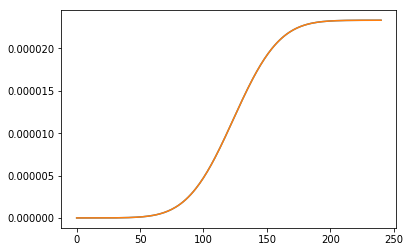

In [19]:
plt.plot(res.time,res.dN_hole)
plt.plot(res.time,res.dN_elec)

We plot the dN_e at the last simulation time in function of the probe frequency

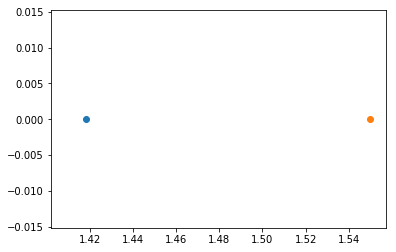

In [20]:
for ind,f in enumerate(freq_range):
    res = yambo_rt.results[ind]
    plt.scatter(f,res.dN_elec[-1])
#plt.ylim((0,2e-3))

In [21]:
yambo_rt.ids

[{'freq': 1.418, 'pol': 'circular'}, {'freq': 1.55, 'pol': 'circular'}]

In [22]:
radical = yambo_rt.names[1]
mgn_file = os.path.join(run_dir_rt,radical,'o-'+radical+'.magnetization')
mgn_file
mgn = C.dict_parser(mgn_file)

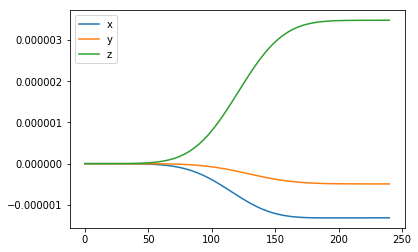

In [23]:
plt.plot(mgn['T'],mgn['Ms_x'],label = 'x')
plt.plot(mgn['T'],mgn['Ms_y'],label = 'y')
plt.plot(mgn['T'],mgn['Ms_z'],label = 'z')
plt.legend()

In [24]:
final_mgn = np.array([mgn['Ms_x'][-1],mgn['Ms_y'][-1],mgn['Ms_z'][-1]])
np.linalg.norm(final_mgn)

3.752392397394631e-06

## ypp post-processing for the rt analysis

Perform the ypp -n o e post-processing using the rt results as input

In [21]:
code = C.YamboCalculator(omp=1,mpi_run='mpirun -np 1',executable='ypp_rt',suffix='YPP-RT_occupations_DATA',skip=True)

Initialize a Yambo calculator with command OMP_NUM_THREADS=1 mpirun -np 1 ypp_rt
Suffix for post_processing :  YPP-RT_occupations_DATA


In [22]:
ypp_noe = D.Dataset(label='ypp_noe',run_dir=run_dir_rt)

In [23]:
ypp_input = I.YppIn('ypp_rt -n o e -V qp',folder=ypp_noe.run_dir)

execute :  cd rt_gamma_width40_no-commutator/FixSymm; ypp_rt -n o e -V qp -F ypp.in


In [24]:
input = ypp_input.getInput()
input['QPkrange'][0][3:5] = rt_bands
input['TimeStep'][0] = 100 #20
print(input)

RealTime
RToccupations
% TimeRange
 -1.000000 | -1.000000 |  fs 
%
% QPkrange
 1 | 1 | 1 | 5 | 10 |   
%
TimeStep = 100 fs
% QPerange
 1 | 1 | 0.0 | -1.000000 |   
%



Add the run the dataset. The names of the yambo_rt are given as jobname to the post-processing

In [25]:
for name in yambo_rt.names: 
    idd = 'ypp_'+name
    ypp_noe.append_run(id=idd,input=ypp_input,calculator=code,jobname=name)

In [26]:
ypp_noe.run()

execute :  cd rt_gamma_width40_no-commutator/FixSymm; ypp_rt -n o e -V qp -F ypp_freq_1.418-pol_circular.in
execute : cd rt_gamma_width40_no-commutator/FixSymm ; OMP_NUM_THREADS=1 mpirun -np 1 ypp_rt -F ypp_freq_1.418-pol_circular.in -J freq_1.418-pol_circular -C ypp_freq_1.418-pol_circular
parse file : rt_gamma_width40_no-commutator/FixSymm/ypp_freq_1.418-pol_circular/o-freq_1.418-pol_circular.YPP-RT_occupations_DATA
execute :  cd rt_gamma_width40_no-commutator/FixSymm; ypp_rt -n o e -V qp -F ypp_freq_1.55-pol_circular.in
execute : cd rt_gamma_width40_no-commutator/FixSymm ; OMP_NUM_THREADS=1 mpirun -np 1 ypp_rt -F ypp_freq_1.55-pol_circular.in -J freq_1.55-pol_circular -C ypp_freq_1.55-pol_circular
parse file : rt_gamma_width40_no-commutator/FixSymm/ypp_freq_1.55-pol_circular/o-freq_1.55-pol_circular.YPP-RT_occupations_DATA


In [27]:
ypp_noe.ids

['ypp_freq_1.418-pol_circular', 'ypp_freq_1.55-pol_circular']

Use the output file for showing the neq occupations

In [28]:
res = ypp_noe.results[0].__dict__
res.keys()

dict_keys(['E', '140.000', '40.0000', '240.000'])

In [29]:
last_time = '240.000'

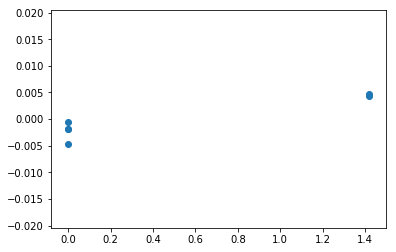

In [30]:
plt.scatter(res['E'],res[last_time])
#plt.ylim(-5e-3,5e-3)